HLM 및 MLM은 간 및 마우스의 간 대사효소와 화합물을 30분 동안 반응시킨 후, 
<대사되지 않고 남아있는 화합물의 양>을(%) LC-MS/MS로 측정함으로써 화합물의 간 대사효소에 대한 안정성을 평가한 데이터
LC-MS/MS : 액체 크로마토그래피 질량 분석(액체 크로마토그래피의 물리적 분리 기능과 질량 분석 기능을 결합한 분석 화학 기술)
복잡한 샘플에서 특정 화합물을 분리, 정량 및 식별하는데 널리 사용

대사 안정성이 낮은 물질의 경우 체내 소실이 빨리, 많이 된다.
적절히 체내에 남아 있으면서 약효가 발휘되어야한다.
가능한 한 신약개발 초기부터 대사안정성이 높은 물질을 선별해야한다.

신약개발의 metabolity 최적화 -> 실험적인 방법과 컴퓨터를 활용한 전략을 병용한 사례가 있음.
일부 약물의 경우 clearance가 높았다고...

------------------------------------------------------------------------------------------------

간 조직을 분리해서 얻은 hepatocyte가 metabolism을 평가하는데 가장 좋지만,
S9, Microsome, cytosol도 있음
간 조직을 경질화 한다음, 낮은 speed로 원심분리하여 얻은 것이 s9,
그 다음 빠른 속도로 원심분리하여, 위에 뜬게 cytosol, 아래 가라앉은게 microsomal
가장 대표적인 enzyme을 포함한 microsome을 이용한 대사 평가가 가장 많이 사용
liver Microsomes in Buffer(Pb 7.4) + Drug -> (NDAPH, 37도에서, CYP450) -> Drug + Drug -OH

주최측에서 준 것은 Single point assay(with / without NADPH가 가능)

대사 안정성 분류 기준
반감기 기준으로 할 경우, 30분 기준 <50% 이면 안정한 물질, 중간은 moderate, <12.4%면 불안정한 물질.
clearance 기준으로 할 경우, ~
다만 우리가 가진건 단지 30분 후 대사물의 양일뿐

------------------------------------------------------------------------------------------------

column들의 의미

id: 화합물의 아이디.
SMILES: 화합물의 SMILES (Simplified Molecular Input Line Entry System) 표기법.
MLM: 화합물의 MLM (Microsomal Liver Metabolism) 값.
HLM: 화합물의 HLM (Human Liver Microsomes) 값.
AlogP: 화합물의 AlogP 값.
Molecular_Weight: 화합물의 분자량.
Num_H_Acceptors: 화합물의 수소 수용체 개수.
Num_H_Donors: 화합물의 수소공여체 개수.
Num_RotatableBonds: 화합물의 회전 가능 결합 개수.
LogD: 화합물의 LogD 값.
Molecular_PolarSurfaceArea: 화합물의 극성 표면적.

------------------------------------------------------------------------------------------------

Lipinski's Rule

- **Rule of five(RO5)** 라고도 불리며 Druglikeness를 판단하는데 사용
- 1997년 Pfizer의 과학자 Christopher A. Lipinski는 구강복용하는 약물이 상대적으로 크기가 작고 지용성이라는 것을 관찰하여 이 규칙을 고안

- ADME(pharmacokinetic)에 기반한 프로파일
- Molecular weight < 500 Dalton
- Octanol-water partition coefficient (LogP) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10

------------------------------------------------------------------------------------------------

In [1]:
import sys
import pandas as pd
import numpy as np
import os
import operator
import string
import re
import random
import warnings
warnings.filterwarnings('ignore')
import platform
import json, pickle
import networkx as nx

from copy import deepcopy
from math import sqrt
from random import shuffle
from collections import OrderedDict
from scipy import stats
from IPython.display import SVG

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import AllChem, rdDepictor, MolFromSmiles, Descriptors, rdMolDescriptors, Crippen, QED, EState, Lipinski, MolSurf, Fragments

import deepchem as dc
from deepchem.feat.molecule_featurizers import MolGraphConvFeaturizer
from deepchem.feat import RDKitDescriptors

import torch_geometric
from torch.nn import Dropout, BatchNorm1d
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, GINConv, global_add_pool, global_max_pool

import sklearn as sk
from sklearn.utils import check_random_state
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import deepchem as dc
from deepchem.splits.splitters import ScaffoldSplitter

# 시각화 라이브러리
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
# What version of Python do you have?
has_gpu = torch.cuda.is_available()
# has_mps = torch.backends.mps.is_built()
device = "cuda" if has_gpu else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.5.2-arm64-arm-64bit
PyTorch Version: 2.0.1

Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]
Pandas 2.1.0
Scikit-Learn 1.3.0
GPU is NOT AVAILABLE
Target device is cpu


In [3]:
CFG = {
    'SEED': 42,
    'TRAIN_BATCH_SIZE' : 32,
    'TEST_BATCH_SIZE' : 32,
    'LR' : 0.0002,
    'LOG_INTERVAL' : 20,
    'NUM_EPOCHS' : 50,
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    check_random_state(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
train.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          3498 non-null   object 
 1   SMILES                      3498 non-null   object 
 2   MLM                         3498 non-null   float64
 3   HLM                         3498 non-null   float64
 4   AlogP                       3496 non-null   float64
 5   Molecular_Weight            3498 non-null   float64
 6   Num_H_Acceptors             3498 non-null   int64  
 7   Num_H_Donors                3498 non-null   int64  
 8   Num_RotatableBonds          3498 non-null   int64  
 9   LogD                        3498 non-null   float64
 10  Molecular_PolarSurfaceArea  3498 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 300.7+ KB


In [7]:
# train 데이터의 SMILES에 있는 분자 알아보기
unique_atoms = set()
for smiles in train['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        unique_atoms.add(atom.GetSymbol())

print(unique_atoms)

{'I', 'Se', 'C', 'O', 'Cl', 'Br', 'F', 'S', 'N'}


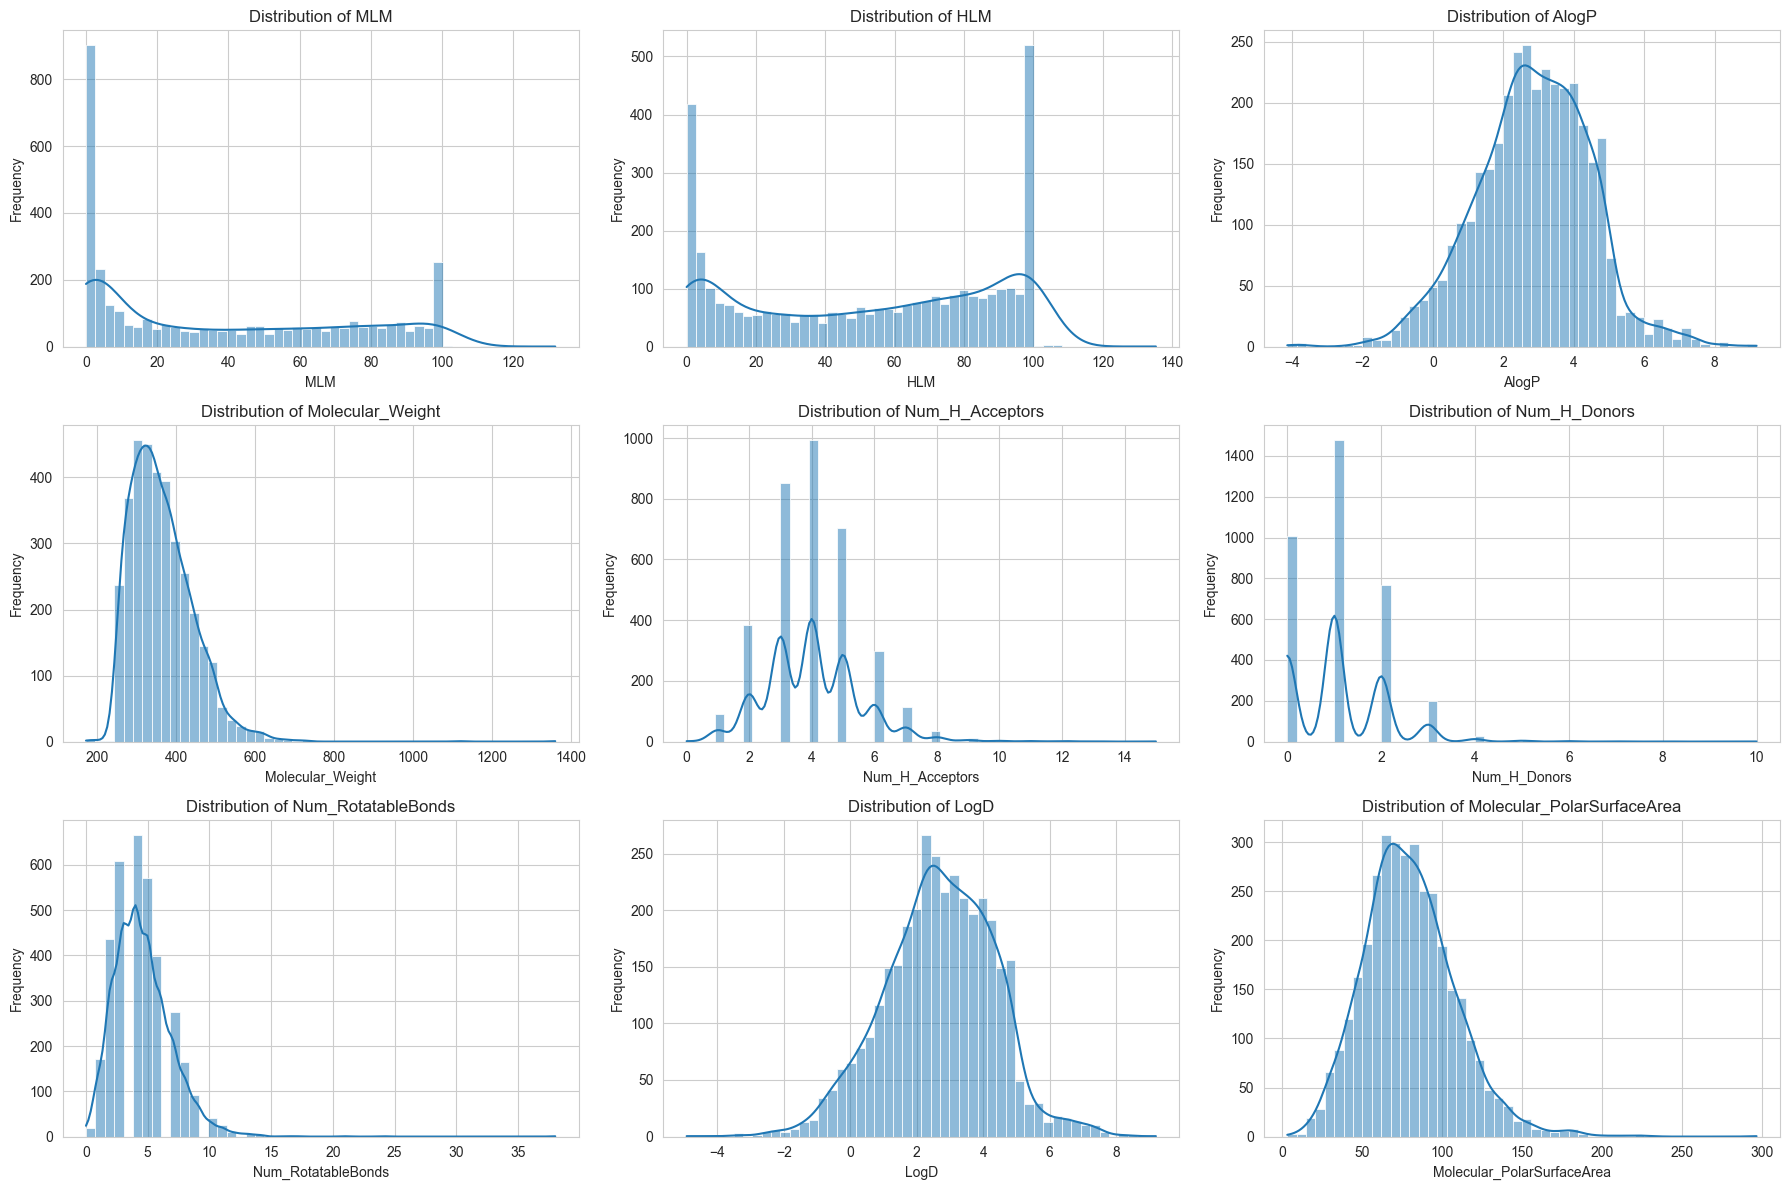

In [8]:
sns.set_style("whitegrid")
plt.figure(figsize=(18, 12))

# Subplots for each feature
features = ["MLM", "HLM", "AlogP", "Molecular_Weight", "Num_H_Acceptors", "Num_H_Donors", "Num_RotatableBonds", "LogD", "Molecular_PolarSurfaceArea"]
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train[feature], bins=50, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

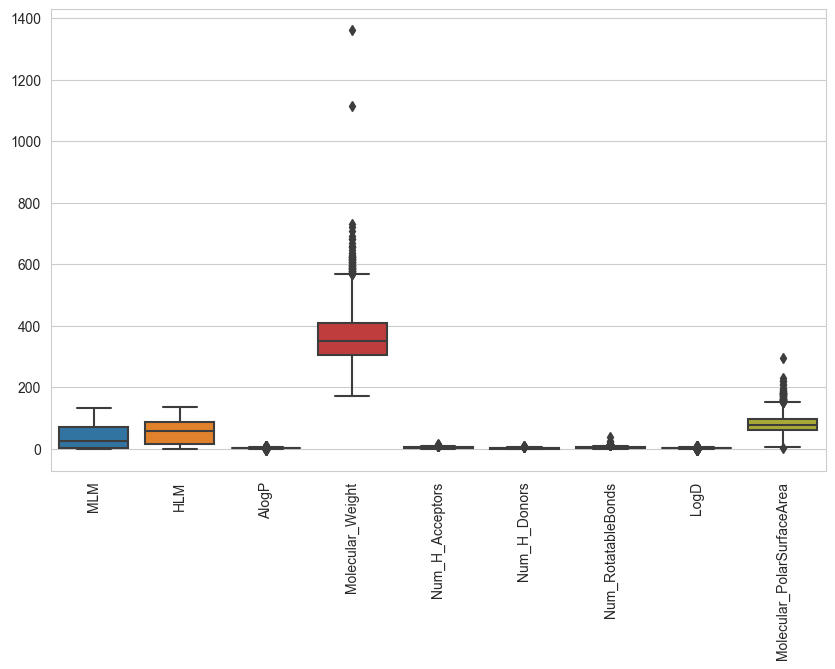

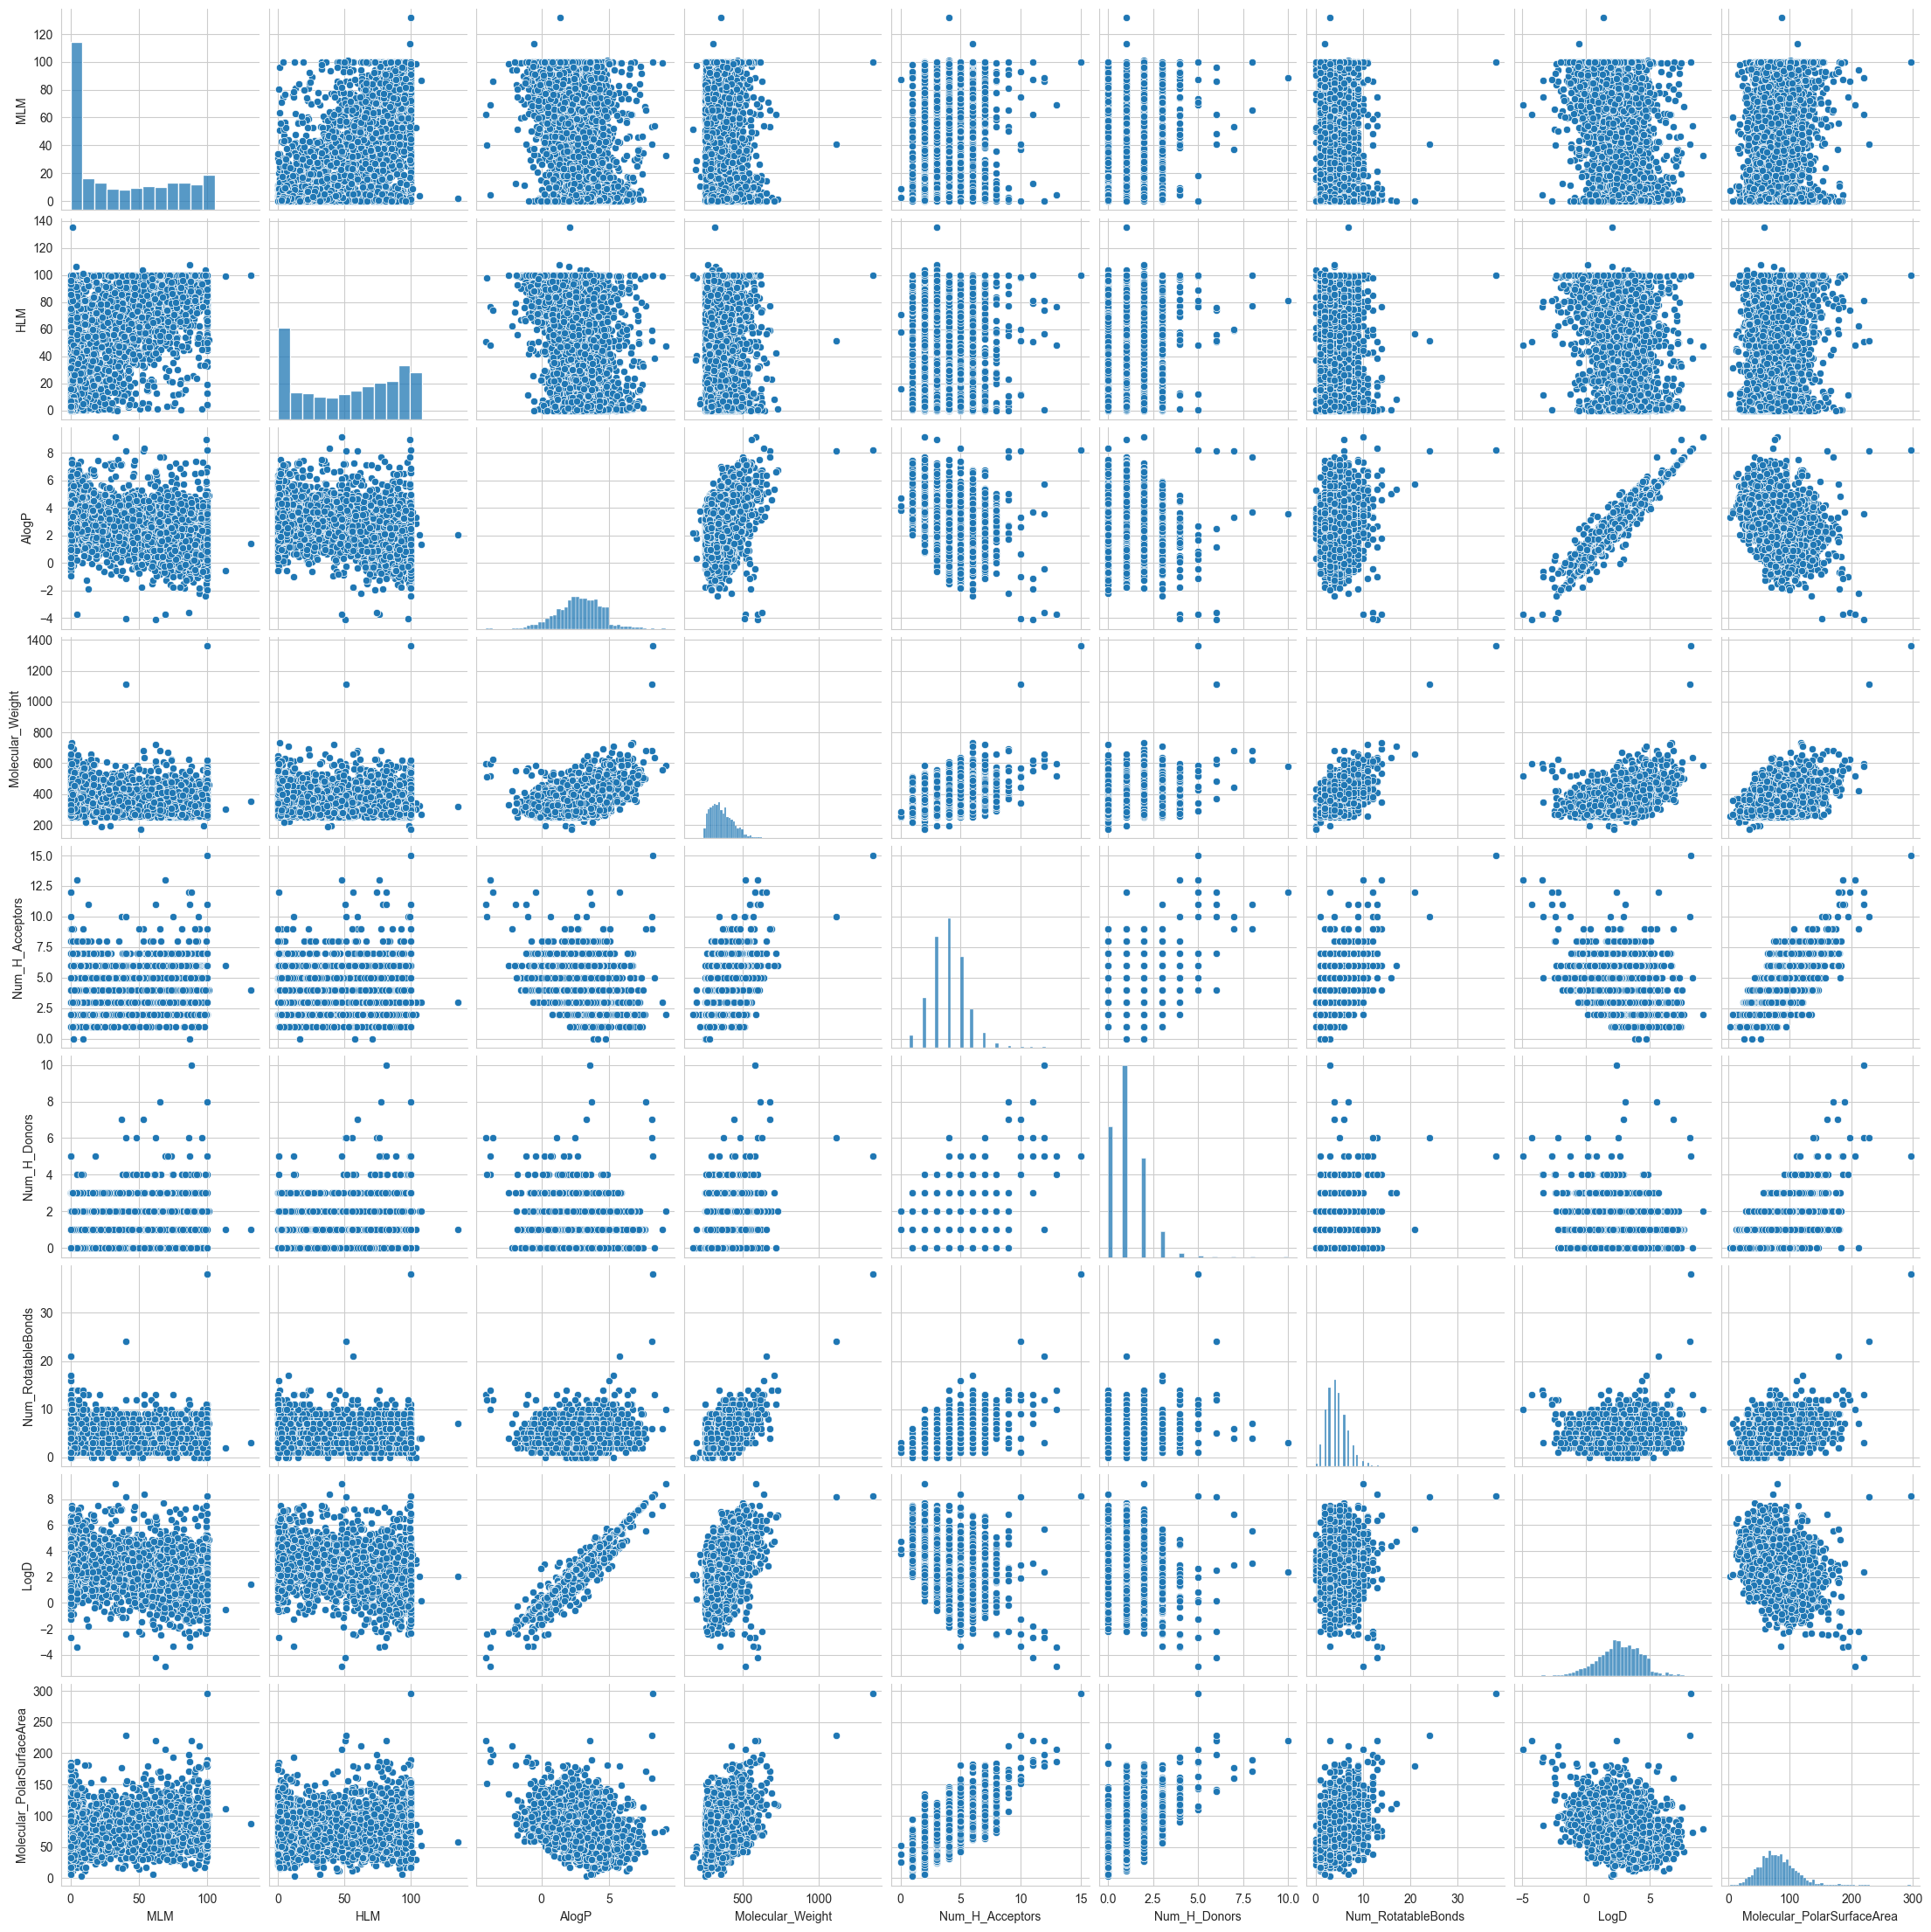

In [9]:
# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=train)
plt.xticks(rotation=90)
plt.show()

# Scatter plot matrix
sns.pairplot(train)
plt.show()

In [10]:
train[train['Molecular_Weight'] >= 1100]

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
1172,TRAIN_1172,COC(=O)c1cc(F)c(NCCCN(CCCCN(CCCn2c(=O)[nH]c3cc...,99.900,99.900,8.241,1360.467,15,5,38,8.257,296.43
2711,TRAIN_2711,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,40.761,51.084,8.163,1115.264,10,6,24,8.156,229.23


In [11]:
# SMILES 열의 데이터를 가져와서 각 문자열의 길이 계산
smiles_lengths = train['SMILES'].str.len()

# 최대 및 최소 길이 확인
min_length = smiles_lengths.min()
max_length = smiles_lengths.max()
min_length_idx = smiles_lengths.idxmin()
max_length_idx = smiles_lengths.idxmax()

min_length, min_length_idx, max_length, max_length_idx

(18, 1399, 174, 1172)

In [12]:
train.iloc[1399]

id                                    TRAIN_1399
SMILES                        Brc1cnc2n[se]nc2c1
MLM                                       91.192
HLM                                         99.9
AlogP                                       1.82
Molecular_Weight                         262.953
Num_H_Acceptors                                3
Num_H_Donors                                   0
Num_RotatableBonds                             0
LogD                                        1.82
Molecular_PolarSurfaceArea                 38.67
Name: 1399, dtype: object

In [13]:
train.iloc[1172]

id                                                                   TRAIN_1172
SMILES                        COC(=O)c1cc(F)c(NCCCN(CCCCN(CCCn2c(=O)[nH]c3cc...
MLM                                                                        99.9
HLM                                                                        99.9
AlogP                                                                     8.241
Molecular_Weight                                                       1360.467
Num_H_Acceptors                                                              15
Num_H_Donors                                                                  5
Num_RotatableBonds                                                           38
LogD                                                                      8.257
Molecular_PolarSurfaceArea                                               296.43
Name: 1172, dtype: object

In [14]:
# 원래 SMILES 문자열에는 수소를 명시적으로 표현하지 않지만, 표현하는 경우도 있음(아미노기, 아미드, 방향족 질소 원자에 붙은 수소원자, 일부러 명시적으로 표시 등)
# 그런 부분을 제외하고, 유효하지 않은 화합물이 있는지 확인하기 위한 위한 함수 불러옴 -> 없음.
allowed_atoms = ["I", "O", "F", "Br", "Se", "C", "N", "Cl", "S", "He", "H"]

def contains_only_allowed_atoms(smiles):
    for atom in allowed_atoms:
        smiles = smiles.replace(atom, "")
    return all(char.islower() or char in ['.', '-', '=', '#', '$', '(', ')', '+', '--', '[', ']', '@', '%', ':', '/', '\\', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] for char in smiles)


# Check if the SMILES contains only the allowed atoms and filter invalid ones
invalid_smiles = train[~train['SMILES'].apply(contains_only_allowed_atoms)]

invalid_smiles_count = len(invalid_smiles)
invalid_smiles_examples = invalid_smiles.head()

invalid_smiles_count, invalid_smiles_examples[['id', 'SMILES']]

(0,
 Empty DataFrame
 Columns: [id, SMILES]
 Index: [])

In [15]:
# MLM, HLM이 100이 넘는 값에 대한 주최측의 답변
'''
논리적으로는 아무리 안정한 물질이라도 100%를 넘는 값은 나올 수 없는 수치입니다.
그러나 간혹 용해도가 극히 좋지 않으면서 대사안정성이 높은 물질의 경우,
37도에서 30분간 반응하며 주어진 시간동안 실험 전보다 용해도가 더 증가하여 
반응 후 % remaining값이 반응 전 대비 더 큰 값으로 계산되는 경우도 발생될 수 있습니다.
모든 실험값들은 본 상황과 같은 문제를 포함하여 편차가 있을 수 있는 다양한 가능성이 있으므로 실측값들을 그대로 게시하였습니다.

-> 용해도가 안좋다 -> 약 흡수가 잘 안된다...
'''
train[(train['MLM'] >= 100) | (train['HLM'] >= 100)]

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
662,TRAIN_0662,O=C(Nc1ccccc1)C1CCCN1C1=NS(=O)(=O)c2ccccc21,131.720,99.570,1.412,355.411,4,1,3,1.412,87.22
1092,TRAIN_1092,COc1c(NC(=O)c2ccc[nH]2)cc(Cl)cc1C(=O)N(C)C,3.820,106.510,2.061,321.759,3,2,4,2.061,74.43
1584,TRAIN_1584,CN(C)S(=O)(=O)CCNCc1ccc(-c2ccccc2)cc1,1.745,135.336,2.075,318.434,3,1,7,2.052,57.79
2159,TRAIN_2159,N#Cc1nccnc1OC1CCN(C(=O)N2CCNC2=O)C1,113.210,99.000,-0.533,302.289,6,1,2,-0.533,111.44
2410,TRAIN_2410,CC(C)CCC1CCN(C(=O)C2CC(O)CN2)CC1,86.878,107.323,1.345,268.395,3,2,4,0.139,52.57
2586,TRAIN_2586,Cc1nc(-c2c[nH]c(C(=O)N3CCOc4cc(F)ccc43)c2)cs1,98.550,103.720,2.876,343.375,3,1,2,3.032,86.46
2948,TRAIN_2948,CCCC(=O)Nc1cc(C(=O)NC2CCCCC2)ccc1S(=O)(=O)c1cc...,101.380,52.330,4.906,462.989,4,2,7,4.906,100.72
3157,TRAIN_3157,CN1C(=O)c2cccc3c2C1=Cc1ccc2ccccc2c1O3,52.847,103.907,3.319,299.323,2,0,0,3.319,29.54
3403,TRAIN_3403,c1cnc2c(C3NCCc4c3[nH]c3ccccc43)cccc2c1,8.890,100.830,3.719,299.369,2,2,1,3.719,40.71


In [16]:
# 중복값에 대한 주최측의 답변

'''
본 데이터는 생물학적 재료를 활용한 실험으로써,
동일 실험 조건이라도 실험 결과는 대사효소의 활성 정도나 반응 시간의 미세한 차이 등 여러가지 요인들에 편차가 발생합니다.
데이터의 신뢰성 확보를 위해, 제공된 대사안정성 데이터 값은 각각 n수를 3으로 하여 평균을 냈으며
MLM에서는 5% 이내, HLM에서는 10% 이내의 값이 나오는지 확인하였으므로, 편차는 제공하지 않습니다.
몇몇 데이터는 실험적 오차가 발생한 것으로 예측됩니다.
중복 값은 배치가 다른 실험에 대한 값입니다.
각 배치마다 reference 물질을 사용하여 확인하였으므로 실험계 전체의 오류는 없으나 batch 중 한 실험은 오류가 있는 것으로 예측되고, 
그와 같은 데이터가 포함될 가능성은 항상 있으므로 그러한 데이터의 처리가 중요하여 경진대회에 포함하였습니다.
'''

duplicate_smiles = train['SMILES'].duplicated(keep=False)
duplicates = train[duplicate_smiles].sort_values(by='SMILES')
duplicates

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2276,TRAIN_2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
451,TRAIN_0451,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.310,24.670,3.556,262.309,3,0,4,3.556,43.60
2891,TRAIN_2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,55.950,69.950,2.172,337.372,4,2,3,2.169,82.00
543,TRAIN_0543,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
837,TRAIN_0837,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,63.522,62.488,2.293,367.428,5,2,3,2.307,139.85
366,TRAIN_0366,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
1085,TRAIN_1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,23.630,71.470,1.684,381.450,7,1,4,1.684,126.52
2848,TRAIN_2848,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
2096,TRAIN_2096,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,1.880,61.280,2.843,360.490,3,0,4,2.843,49.85
1666,TRAIN_1666,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,5.494,25.397,2.843,360.490,3,0,4,2.843,49.85


In [17]:
# 중복된 MLM, HLM의 표준편차를 계산
mlm_std_dev = duplicates.groupby('SMILES')['MLM'].std()
hlm_std_dev = duplicates.groupby('SMILES')['HLM'].std()

variability_df = pd.DataFrame({
    'MLM_Std_Dev': mlm_std_dev,
    'HLM_Std_Dev': hlm_std_dev,
}).reset_index()

variability_df = variability_df.sort_values(by='MLM_Std_Dev', ascending=False)

variability_df

,SMILES,MLM_Std_Dev,HLM_Std_Dev
25,N#Cc1nccnc1OC1CCN(C(=O)N2CCNC2=O)C1,80.046609,69.976701
6,CC1CC(=O)N(c2ccc(-c3cccc(C#N)c3)cc2)N=C1c1ccc(...,61.051599,44.024468
10,CN(C)c1ccc(C2c3cccn3-c3sc4c(c3CN2C(=O)NCc2cccc...,58.271256,55.995079
24,N#Cc1nccnc1OC1CCN(C(=O)C2CC(=O)N(C3CCOCC3)C2)C1,41.980930,8.570134
5,CC(C)NC(=O)c1c(Cl)nn(C)c1NC(=O)c1cc(Br)nn1-c1n...,36.597726,24.043752
23,Cc1ccccc1-c1nc2ccccc2cc1C(C)n1c(=O)[nH]c2c(S(C...,34.488426,38.407212
9,CCc1nc2cc(Br)c(C(=O)OC)nc2n1CC(=O)c1ccccc1,31.996582,0.290621
13,COCCOc1cc(=O)n2c(c1C(=O)N1CCCC1)CCOCC2,23.801214,6.045763
18,COc1cccc(-c2cc(-c3nc4c5cnn(-c6ccccc6)c5ncn4n3)...,18.257497,23.777880
21,Cc1ccc(-c2cc(-c3nc4c5ccccc5ncn4n3)[nH]n2)c(C)c1,16.527914,11.899900


In [18]:
# Calculate the absolute difference for each duplicate pair in 'duplicates' dataframe
duplicates['abs_diff'] = (duplicates['MLM'] - duplicates['HLM']).abs()

# Create a list to store indices to keep and indices to drop
indices_to_keep = []
indices_to_drop = []

# Iterate over the 'duplicates' dataframe with a step of 2 (since they are pairs)
for i in range(0, len(duplicates), 2):
    row1 = duplicates.iloc[i]
    row2 = duplicates.iloc[i + 1]
    
    # Calculate the difference in the absolute differences for the pair
    diff_of_diffs = abs(row1['abs_diff'] - row2['abs_diff'])
    
    # If the difference in the absolute differences is greater than 30, drop both rows
    if diff_of_diffs > 30:
        indices_to_drop.extend([row1.name, row2.name])
    else:
        # Otherwise, keep one row with maximum MLM and HLM values
        max_MLM = max(row1['MLM'], row2['MLM'])
        max_HLM = max(row1['HLM'], row2['HLM'])
        
        # Update the MLM and HLM values of the first row of the pair with the maximum values
        duplicates.at[row1.name, 'MLM'] = max_MLM
        duplicates.at[row1.name, 'HLM'] = max_HLM
        
        # Keep the first row and drop the second row of the pair
        indices_to_keep.append(row1.name)
        indices_to_drop.append(row2.name)

# Filter out the rows from 'duplicates' dataframe
filtered_duplicates = duplicates.loc[indices_to_keep]

filtered_duplicates

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,abs_diff
2276,TRAIN_2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60,29.918
2891,TRAIN_2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00,14.000
837,TRAIN_0837,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85,1.034
1085,TRAIN_1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52,47.840
1285,TRAIN_1285,CC(C)NC(=O)c1c(Cl)nn(C)c1NC(=O)c1cc(Br)nn1-c1n...,87.987,85.103,3.750,501.165,5,2,5,3.750,106.72,2.884
328,TRAIN_0328,CC1CC(=O)N(c2ccc(-c3cccc(C#N)c3)cc2)N=C1c1ccc(...,86.340,62.260,4.449,381.427,4,1,3,4.446,76.69,24.080
859,TRAIN_0859,CCCCC/N=c1\n(C)c(=O)nc2sccn12,2.860,37.769,2.484,252.336,4,0,4,2.474,73.56,33.000
2534,TRAIN_2534,CCOC(=O)CC1(NC(=O)N2Cc3c(sc4c3CCCC4)-n3cccc3C2...,5.884,5.540,6.727,537.736,3,1,6,6.727,120.05,4.221
1793,TRAIN_1793,CN(C)c1ccc(C2c3cccn3-c3sc4c(c3CN2C(=O)NCc2cccc...,82.778,86.729,6.501,496.666,1,1,4,6.501,68.74,3.951
1914,TRAIN_1914,COC(=O)C1(CCCN(C)CCc2ccc(OC)c(OC)c2)CCCc2c1ccc...,12.690,17.971,5.374,485.612,7,0,13,3.870,66.46,0.440


In [19]:
# Remove the original duplicates from the train dataframe
train = train.drop(indices_to_drop)

# Append the processed duplicates to the train dataframe
train = pd.concat([train, filtered_duplicates])

train.drop('abs_diff', axis=1, inplace=True)

# Sort the dataframe by index for consistency
train.reset_index(inplace=True, drop=True)

train.head(10)

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43
5,TRAIN_0005,COc1c(F)c(F)cc2c(=O)c(C(=O)NCCCN3CCCC3=O)cn(C3...,27.640,66.630,1.335,419.422,4,1,7,1.335,78.95
6,TRAIN_0006,CN(C)c1cccc2c(S(=O)(=O)NC(CC(=O)O)C(=O)O)cccc12,82.107,69.250,1.954,547.707,7,4,9,0.464,144.42
7,TRAIN_0007,C1=Cn2nc(/C=C/c3cccs3)nc2-c2ccccc2O1,2.673,25.121,2.967,293.343,3,0,2,2.967,68.18
8,TRAIN_0008,COc1ccc2nc(C3=CCCN(C)C3)n(C)c2c1,74.519,71.471,-0.946,347.366,7,2,3,-0.723,104.89
9,TRAIN_0009,CCN1CCCC1CNC(=O)C1CCCN(c2ncnc3[nH]cnc23)C1,73.417,76.291,1.259,357.453,5,2,5,-0.373,90.04


In [20]:
# id는 drop, AlogP 결측치는 LogD로 대체
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)
train['AlogP'].fillna(train['LogD'], inplace=True)
test['AlogP'].fillna(test['LogD'], inplace=True)

In [21]:
# SMILES에서 뽑아올 수 있는 요소 중, MLM / HLM과 상관관계 높은 것들.
train['Mol'] = train['SMILES'].apply(Chem.MolFromSmiles)
test['Mol'] = test['SMILES'].apply(Chem.MolFromSmiles)

descriptor_functions = [
    Descriptors.FpDensityMorgan1, Descriptors.FpDensityMorgan2, Descriptors.MaxPartialCharge
]

Estate_functions = [
    EState.EState_VSA.EState_VSA1, EState.EState_VSA.EState_VSA2, EState.EState_VSA.EState_VSA4, EState.EState_VSA.EState_VSA7, 
    EState.EState_VSA.EState_VSA8, EState.EState_VSA.EState_VSA10, EState.EState.MaxEStateIndex, EState.EState.MinEStateIndex,
]

Lipinski_functions = [
    Lipinski.NHOHCount, Lipinski.NOCount, Lipinski.NumAromaticCarbocycles,
    Lipinski.NumAromaticRings, Lipinski.NumHeteroatoms, Lipinski.RingCount,
    Lipinski.NumSaturatedHeterocycles, Lipinski.NumSaturatedRings,
]
Lipinski_function_names = ["NHOHCount", "NOCount", "NumAromaticCarbocycles", "NumAromaticRings", "NumHeteroatoms", "RingCount", "NumSaturatedHeterocycles", "NumSaturatedRings"]

MolSurf_functions = [
    MolSurf.LabuteASA, MolSurf.PEOE_VSA13, MolSurf.PEOE_VSA14, MolSurf.PEOE_VSA2, 
    MolSurf.PEOE_VSA3,  MolSurf.PEOE_VSA6, MolSurf.PEOE_VSA7, MolSurf.SMR_VSA1, 
    MolSurf.SMR_VSA3, MolSurf.SMR_VSA4, MolSurf.SMR_VSA5, MolSurf.SMR_VSA7, 
    MolSurf.SlogP_VSA3, MolSurf.SlogP_VSA5, MolSurf.SlogP_VSA6, MolSurf.TPSA, 
]
MolSurf_function_names = ["LabuteASA", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA6", "PEOE_VSA7", "SMR_VSA1",
                        "SMR_VSA3", "SMR_VSA4", "SMR_VSA5", "SMR_VSA7", "SlogP_VSA3", "SlogP_VSA5", "SlogP_VSA6", "TPSA"]

Fragments_functions = [
    Fragments.fr_Al_COO, Fragments.fr_Al_OH_noTert, Fragments.fr_Ar_COO, Fragments.fr_Ar_N, Fragments.fr_Ar_NH, 
    Fragments.fr_Ar_OH, Fragments.fr_COO, Fragments.fr_C_O, Fragments.fr_NH0, Fragments.fr_amide, 
    Fragments.fr_benzene, Fragments.fr_NH1, Fragments.fr_Ndealkylation2, Fragments.fr_Nhpyrrole, Fragments.fr_ester, 
    Fragments.fr_ether, Fragments.fr_bicyclic, Fragments.fr_ketone, Fragments.fr_para_hydroxylation, Fragments.fr_phenol, 
    Fragments.fr_phenol_noOrthoHbond, Fragments.fr_thiophene,
    ]
Fragments_function_names = ["fr_Al_COO", "Al_OH_noTert", "Ar_COO", "fr_Ar_N", "fr_Ar_NH", "fr_Ar_OH", "fr_COO2", "fr_C_O", "fr_NH0", "fr_amide", "fr_benzene",
                            "fr_NH1", "fr_Ndealkylation2", "fr_Nhpyrrole", "fr_ester", "fr_ether", "fr_bicyclic", "fr_ketone", "fr_para_hydroxylation", 
                            "fr_phenol", "fr_phenol_noOrthoHbond", "fr_thiophene",]

def count_alcohol_substructures(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        alcohol_pattern = Chem.MolFromSmarts('[OX2H]')
        return len(mol.GetSubstructMatches(alcohol_pattern))
    except:
        return None

for func in descriptor_functions:
    train[func.__name__] = train['Mol'].apply(func)
    test[func.__name__] = test['Mol'].apply(func)

for func in Estate_functions:
    train[func.__name__] = train['Mol'].apply(func)
    test[func.__name__] = test['Mol'].apply(func)

for idx, func in enumerate(Lipinski_functions):
    col_name = Lipinski_function_names[idx]
    train[col_name] = train['Mol'].apply(func)
    test[col_name] = test['Mol'].apply(func)

for idx, func in enumerate(MolSurf_functions):
    col_name = MolSurf_function_names[idx]
    train[col_name] = train['Mol'].apply(func)
    test[col_name] = test['Mol'].apply(func)

for idx, func in enumerate(Fragments_functions):
    col_name = Fragments_function_names[idx]
    train[col_name] = train['Mol'].apply(func)
    test[col_name] = test['Mol'].apply(func)
    
train['QED'] = train['Mol'].apply(QED.qed)
test['QED'] = test['Mol'].apply(QED.qed)
train['Alcohol_Count'] = train['SMILES'].apply(count_alcohol_substructures)
test['Alcohol_Count'] = test['SMILES'].apply(count_alcohol_substructures)

# Drop the 'Mol' column
train.drop(columns=['Mol'], inplace=True)
test.drop(columns=['Mol'], inplace=True)

# Display the first few rows of the dataset with the new columns
train.head()

,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,...,fr_ester,fr_ether,fr_bicyclic,fr_ketone,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_thiophene,QED,Alcohol_Count
0,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37,...,0,2,0,0,0,0,0,0,0.598984,0
1,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47,...,0,0,1,0,2,0,0,0,0.924896,0
2,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45,...,0,0,3,0,0,0,0,0,0.723816,0
3,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60,...,0,0,0,0,0,0,0,0,0.535042,0
4,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43,...,0,1,1,0,0,0,0,0,0.798359,0


In [22]:
# 아래 칼럼 결측값 처리
columns_to_fill = ['MaxPartialCharge']
train[columns_to_fill] = train[columns_to_fill].fillna(0)
test[columns_to_fill] = test[columns_to_fill].fillna(0)

# Verify if there are any missing values left
missing_after_fill = train[train[columns_to_fill].isnull().any(axis=1)]

missing_after_fill[columns_to_fill]

,MaxPartialCharge


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 69 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SMILES                      3486 non-null   object 
 1   MLM                         3486 non-null   float64
 2   HLM                         3486 non-null   float64
 3   AlogP                       3486 non-null   float64
 4   Molecular_Weight            3486 non-null   float64
 5   Num_H_Acceptors             3486 non-null   int64  
 6   Num_H_Donors                3486 non-null   int64  
 7   Num_RotatableBonds          3486 non-null   int64  
 8   LogD                        3486 non-null   float64
 9   Molecular_PolarSurfaceArea  3486 non-null   float64
 10  FpDensityMorgan1            3486 non-null   float64
 11  FpDensityMorgan2            3486 non-null   float64
 12  MaxPartialCharge            3486 non-null   float64
 13  EState_VSA1                 3486 

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 67 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SMILES                      483 non-null    object 
 1   AlogP                       483 non-null    float64
 2   Molecular_Weight            483 non-null    float64
 3   Num_H_Acceptors             483 non-null    int64  
 4   Num_H_Donors                483 non-null    int64  
 5   Num_RotatableBonds          483 non-null    int64  
 6   LogD                        483 non-null    float64
 7   Molecular_PolarSurfaceArea  483 non-null    float64
 8   FpDensityMorgan1            483 non-null    float64
 9   FpDensityMorgan2            483 non-null    float64
 10  MaxPartialCharge            483 non-null    float64
 11  EState_VSA1                 483 non-null    float64
 12  EState_VSA2                 483 non-null    float64
 13  EState_VSA4                 483 non

In [25]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

In [26]:
def atom_features(atom, mol): # 52
    features = one_of_k_encoding(atom.GetSymbol(),['N', 'S', 'F', 'Cl', 'Se', 'Br', 'O', 'C', 'I', 'P'])
    features += one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    features += one_of_k_encoding(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    features += one_of_k_encoding(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    features.append(atom.GetIsAromatic())
    features += one_of_k_encoding(atom.GetFormalCharge(), [-1, 0, 1])  # 형식 전하
    features += one_of_k_encoding(str(atom.GetHybridization()), ['SP', 'SP2', 'SP3', 'SP3D', 'SP3D2'])  # 혼성
    
    return np.array(features)

In [27]:
# Returns : 원자 개수, 원자 특성 행렬, 인접 행렬
def smile_to_graph(smile):
    # SMILES 문자열로부터 분자 그래프 데이터 생성
    mol = Chem.MolFromSmiles(smile)
    
    # mol.GetNumAtoms() : 분자에 소속되어 있는 원자의 개수
    c_size = mol.GetNumAtoms()
    
    features = []

    # 분자에 소속되어 있는 원자들을 순회하면서 원자 특성 정보 수집
    for atom in mol.GetAtoms():
        feature = atom_features(atom, mol)
        # 정규화?
        features.append( feature / sum(feature) )

    edges = []
    # 분자를 이루는 원자들의 연결 구조 정보를 순회하면서 인접 정보 수집
    # 연결 구조 정보 : 시작 원자 index, 끝 원자 index
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])

    # 연결 구조 정보를 통한 방향 그래프 생성(양방향)
    g = nx.Graph(edges).to_directed()
    edge_index = []
    for e1, e2 in g.edges:
        edge_index.append([e1, e2])

    return c_size, features, edge_index

In [28]:
smile_graph = {}
for df in [train, test]:
    smiles = df['SMILES']
    for smile in smiles:
        g = smile_to_graph(smile)
        smile_graph[smile] = g

In [29]:
dataset = dc.data.NumpyDataset(X=np.array(train['SMILES']), ids=train['SMILES'].values)
splitter = dc.splits.ScaffoldSplitter()
train_dataset, valid_dataset = splitter.train_test_split(dataset, frac_train=0.85, seed=CFG['SEED'])
train_df = train[train['SMILES'].isin(train_dataset.ids)]
valid_df = train[train['SMILES'].isin(valid_dataset.ids)]

In [ ]:
class TestbedDataset(Dataset):
    def __init__(self, df, mode='train', transform=None, pre_transform=None, smile_graph=None, scaler=None):
        super(TestbedDataset, self).__init__(root=None, transform=transform, pre_transform=pre_transform)
        self.mode = mode
        self.smile_graph = smile_graph
        self.scaler = scaler
        
        self.xd = df['SMILES'].tolist()

        if self.mode == 'train':
            self.y = df[['MLM', 'HLM']].values.tolist()
        else:  # 'test' mode
            self.y = [None] * len(self.xd)

        if self.mode == 'train':
            exclude_cols = ['SMILES', 'MLM', 'HLM']
            additional_data = df.drop(exclude_cols, axis=1)
        
        else:
            additional_data = df.drop('SMILES', axis=1)

        if self.mode == 'train':
            self.scaler = StandardScaler()
            self.scaled_data = self.scaler.fit_transform(additional_data)
        elif self.mode == 'test' and self.scaler is not None:
            self.scaled_data = self.scaler.transform(additional_data)
        else:
            raise ValueError("Scaler should be provided for test mode.")

    def len(self):
        return len(self.xd)

    def get(self, idx):
        smiles = self.xd[idx]
        labels = self.y[idx]
        additional_features = self.scaled_data[idx]

        c_size, features, edge_index = self.smile_graph[smiles]

        data = Data(x=torch.Tensor(features),
                    edge_index=torch.LongTensor(edge_index).transpose(1, 0))
        
        if labels:
            data.y = torch.FloatTensor([labels])
        data.c_size = torch.LongTensor([c_size])
        data.additional_features = torch.Tensor(additional_features)

        return data

In [ ]:
train_dataset = TestbedDataset(df=train_df, mode='train', smile_graph=smile_graph)
val_dataset = TestbedDataset(df=valid_df, mode='train', smile_graph=smile_graph, scaler=train_dataset.scaler)
test_dataset = TestbedDataset(df=test, mode='test', smile_graph=smile_graph, scaler=train_dataset.scaler)

In [ ]:
batch = next(iter(train_dataset))
batch

In [ ]:
class GATNet(torch.nn.Module):
    def __init__(self, n_output=2, num_features_xd=52, output_dim=128, dropout=0.2, num_additional_features=66):
        super(GATNet, self).__init__()

        dim = 32
        heads = 4  # Number of attention heads

        # 약물 분자 표현을 위한 GAT 층 구성
        self.dropout = Dropout(dropout)
        self.relu = ReLU()
        self.n_output = n_output

        self.conv1 = GATConv(num_features_xd, dim, heads=heads, concat=True)
        self.bn1 = BatchNorm1d(dim * heads)
        self.conv2 = GATConv(dim * heads, dim, heads=heads, concat=True)
        self.conv3 = GATConv(dim * heads, dim, heads=heads, concat=True)
        self.fc1_xd = Linear(dim * heads, output_dim)

        # Additional Features Fully Connected Layer
        self.fc_additional = Linear(num_additional_features, output_dim)

        # Concatenation
        self.fc1 = Linear(2 * output_dim, 1024)
        self.fc2 = Linear(1024, 256)
        self.out = Linear(256, self.n_output)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        additional_features = data.additional_features.view(-1, 66)

        # Molecular features
        x = F.elu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        x = global_add_pool(x, batch)
        x = F.elu(self.fc1_xd(x))
        x = self.dropout(x)

        # Process additional features
        additional_out = self.fc_additional(additional_features)
        additional_out = F.elu(additional_out)
        additional_out = self.dropout(additional_out)

        # Concatenation
        xc = torch.cat((x, additional_out), 1)
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out

In [ ]:
def custom_loss(y_pred, y_true):
    loss1 = nn.mse_loss(y_pred[:, 0].flatten(), y_true[:, 0].flatten())
    loss2 = nn.mse_loss(y_pred[:, 1].flatten(), y_true[:, 1].flatten())
    return (loss1**0.5 + loss2**0.5) / 2

In [ ]:
def training(model, device, train_loader, optimizer, epoch):
    print('Training on {} samples...'.format(len(train_loader.dataset)))
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        # Adjusting the shape of target data to match the output
        loss1 = F.mse_loss(output[:, 0].flatten(), data.y[:, 0].to(device).flatten())
        loss2 = F.mse_loss(output[:, 1].flatten(), data.y[:, 1].to(device).flatten())
        loss = (loss1**0.5 + loss2**0.5) / 2

        loss.backward()
        optimizer.step()

        if batch_idx % LOG_INTERVAL == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * train_loader.batch_size,
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))

In [ ]:
def predicting(model, device, loader, mode='validation'):
    model.eval()

    # 학습을 통해 예측된 값을 저장합니다.
    total_preds = []

    # 실제 값을 저장합니다.
    total_labels = []

    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            total_preds.append(output.cpu().numpy())
            
            # 만약 mode가 'test'가 아니라면 실제 값을 저장
            if mode != 'test':
                total_labels.append(data.y.cpu().numpy())
    
    # 리스트를 numpy 배열로 변환합니다.
    if mode == 'test':
        return np.vstack(total_preds)
    else:
        return np.vstack(total_labels), np.vstack(total_preds)

In [ ]:
TRAIN_BATCH_SIZE = CFG['TRAIN_BATCH_SIZE']
TEST_BATCH_SIZE = CFG['TEST_BATCH_SIZE']
LR = CFG['LR']
LOG_INTERVAL = CFG['LOG_INTERVAL']
NUM_EPOCHS = CFG['NUM_EPOCHS']

In [ ]:
def rmse(y,f):
    rmse = np.sqrt(((y - f)**2).mean(axis=0))
    return rmse

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=TRAIN_BATCH_SIZE)

model = GATNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

model_file_name = 'GATNet.model'

for epoch in range(NUM_EPOCHS):
    training(model, device, train_loader, optimizer, epoch+1)
    G, P = predicting(model, device, val_loader)
    ret = rmse(G,P)

    print('rmse at epoch {}; best_rmse: {:.4f}'.format(epoch, ret))

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

In [ ]:
preds = predicting(model, device, test_loader, mode='test')
preds

In [ ]:
sample_submission = pd.read_csv('Data/sample_submission.csv')
sample_submission

In [ ]:
sample_submission['MLM'] = preds[:, 0]
sample_submission['HLM'] = preds[:, 1]
sample_submission

In [ ]:
sample_submission.to_csv('submission.csv', index=False)